## Analisis Exploratorio (EDA):

In [114]:
# cargar el archivo CSV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('spotify_likes.csv')
audio_feature_numerical_keys = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence',
]
audio_feature_categorical_keys = ['tempo', 'time_signature', 'key', 'mode']

#### Resumen estadistico
Observamos que los datos numericos se encuentran normalizados [0-1] a excepcion del volumen

In [115]:
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,key,mode
count,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000
mean,0.614336,0.723367,-6.652056,0.103882,0.221417,0.073948,0.192347,0.603167,120.920900,3.915937,5.316988,0.513135
std,0.151183,0.197671,3.615472,0.103663,0.267174,0.226306,0.150128,0.229578,31.263901,0.392842,3.573201,0.500266
min,0.000000,0.014600,-31.047000,0.000000,0.000018,0.000000,0.032400,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.516000,0.618000,-7.750500,0.039750,0.016950,0.000000,0.096200,0.440000,95.031500,4.000000,2.000000,0.000000
50%,0.621000,0.766000,-5.782000,0.061200,0.098100,0.000001,0.135000,0.618000,115.063000,4.000000,6.000000,1.000000
75%,0.723000,0.870500,-4.397000,0.116000,0.359000,0.000420,0.249000,0.794500,144.082500,4.000000,9.000000,1.000000
max,0.940000,0.991000,1.099000,0.841000,0.994000,0.973000,0.984000,0.978000,207.771000,5.000000,11.000000,1.000000


Algunos generos no pudieron ser recuperados. Si la tasa de error es menor al 10% imputaremos la esta var cualitativa nominal con la moda.

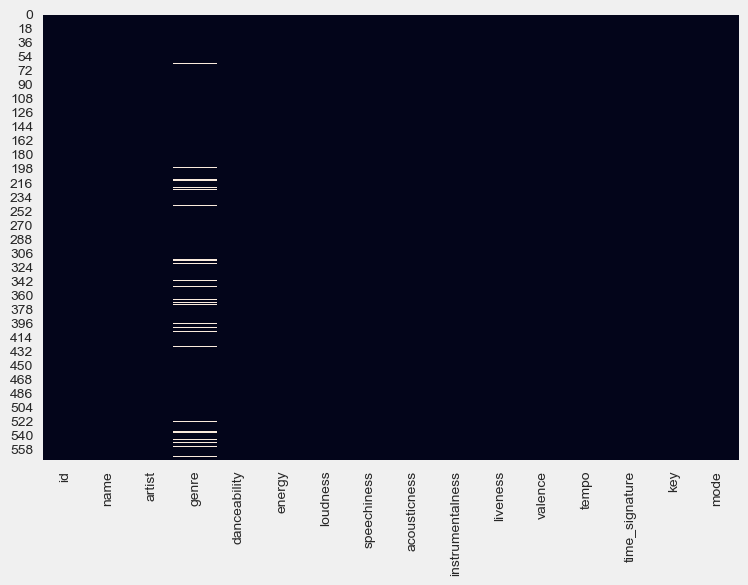

Filas con valores nulos: 35
Se imputo 6.13% del genero con la moda rock uruguayo
Filas con valores nulos: 0


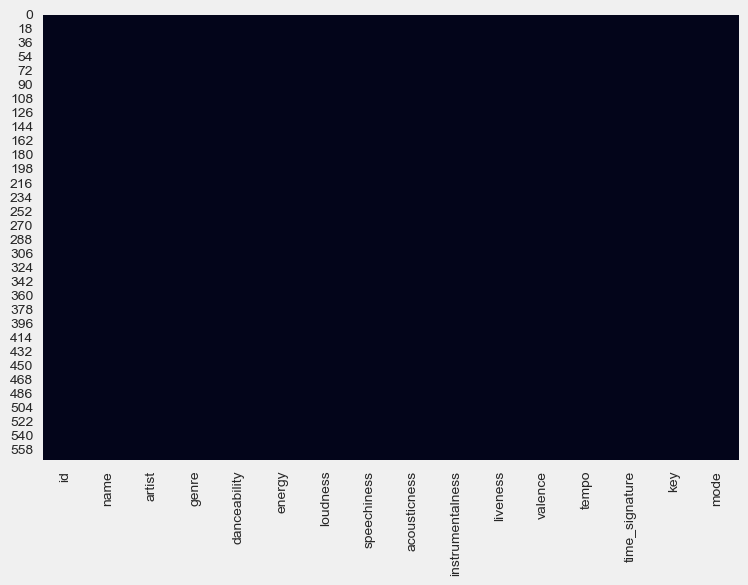

Filas duplicadas eliminadas: 0


In [116]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()
print(f'Filas con valores nulos: {df.isnull().sum().sum()}')

percent_null_genre = df['genre'].isnull().sum() / len(df)

if percent_null_genre < 0.1 and percent_null_genre > 0:
    moda = df["genre"].mode()[0]
    df['genre'] = df['genre'].fillna(moda)
    print(f'Se imputo {percent_null_genre:.2%} del genero con la moda {moda}') 
    print(f'Filas con valores nulos: {df.isnull().sum().sum()}')
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()
else:
    print(f'No se imputo el genero porque el porcentaje de nulos es {percent_null_genre:.2%}')

n = len(df)
df = df.drop_duplicates()
print(f'Filas duplicadas eliminadas: {n - len(df)}')




#### Distribución de las variables

La interpretacion de las variables del analisis del audio de las canciones se realiza de acuerdo a [Anero, 2020](https://www.linkedin.com/pulse/tendencias-hist%C3%B3ricas-del-%C3%A9xito-musical-trav%C3%A9s-de-los-gonzalo/):

Para este usuario en particular, observamos 

##### 1. Danceability
- **Distribución**: Ligeramente sesgada hacia la izquierda, con un pico entre 0.6 - 0.8.
- **Interpretación**: Las canciones de este usuario suelen ser bastante bailables, con tendencia a un "danceability" alto.

##### 2. Energy
- **Distribución**: Sesgada hacia la derecha, con un pico entre 0.7 - 0.9.
- **Interpretación**: Las canciones del usuario suelen ser bastante energéticas, con tendencia a un "energy" muy alto.

##### 3. Loudness
- **Distribución**: Pico muy definido entre -10db y 0db.
- **Interpretación**: Las canciones del usuario suelen tener un volumen bastante alto.

##### 4. Speechiness
- **Distribución**: Muy sesgada hacia la izquierda (0.0 - 0.2).
- **Interpretación**: En la mayoría de las canciones del usuario la letra no se recita, sino que se canta.

##### 5. Acousticness
- **Distribución**: Extremadamente sesgada hacia la izquierda.
- **Interpretación**: La mayoría de las canciones son producidas con poca influencia acústica, sugiriendo un énfasis en la producción digital.

##### 6. Instrumentalness
- **Distribución**: Muy sesgada a la izquierda, con valores cercanos a 0. 
- **Interpretación**: Esto indica que la mayoría de las canciones en el dataset tienen letras.

##### 7. Liveness
- **Distribución**: Sesgada hacia la izquierda, con una gran cantidad de valores bajos.
- **Interpretación**: La mayoría de las canciones no son grabaciones en vivo.

##### 8. Valence
- **Distribución**: Pico entre 0.6 - 0.8, con inclinación hacia la derecha.
- **Interpretación**: La mayoría de las canciones tienen una valencia alta, sonando felices o alegres, con variedad en canciones de tono más neutral.

#### Observaciones extra.
- Danceability incluye el tempo, la estabilidad rítmica, la intensidad del pulso y la regularidad general, serian candidatos a excluir de nuestro modelo de clustering.
- Ademas, seria conveniente incluir la duracion dado que varia por rango de años.

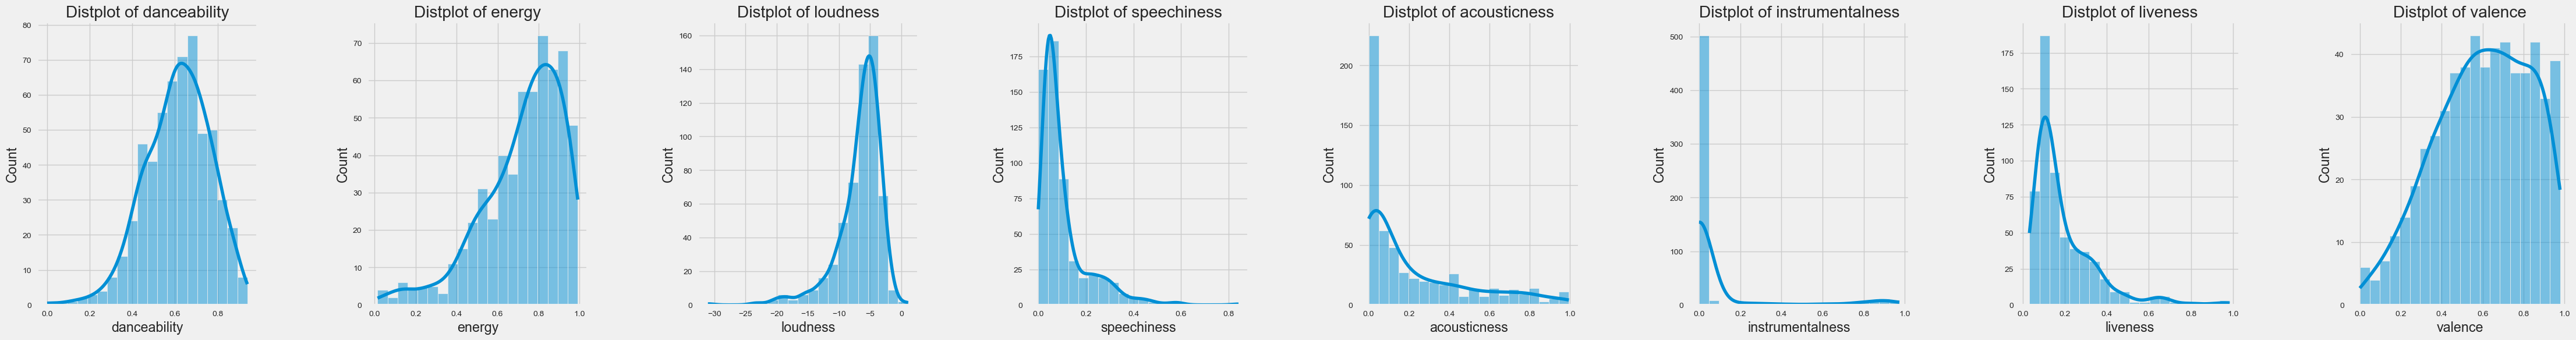

In [117]:
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (50 , 6))
n = 0 
for x in audio_feature_numerical_keys:
    n += 1
    plt.subplot(1 , len(audio_feature_numerical_keys) , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.histplot(df[x] , bins = 20, kde=True)
    plt.title('Distplot of {}'.format(x))
plt.show()

#### Analsis de Correlacion
Se busca identificar relaciones importantes entre las caractersticas para decidir como enfocar el modelo de clasificacion. Esto se hace par mantener simplicidad y minimizar el riesgo de sobreajuste (para que no aprenda ruido mi gallo)

1. La energia y el volumen de las canciones estan estrechamente ligadas. (directa)
2. Las canciones acusticas tienden a ser menos energeticas y menos rudidosas. (inversa)
3. La danzabilidad y la valencia estan ligeramente relacionadas, las canciones alegres deben ser mas bailables. (directa)

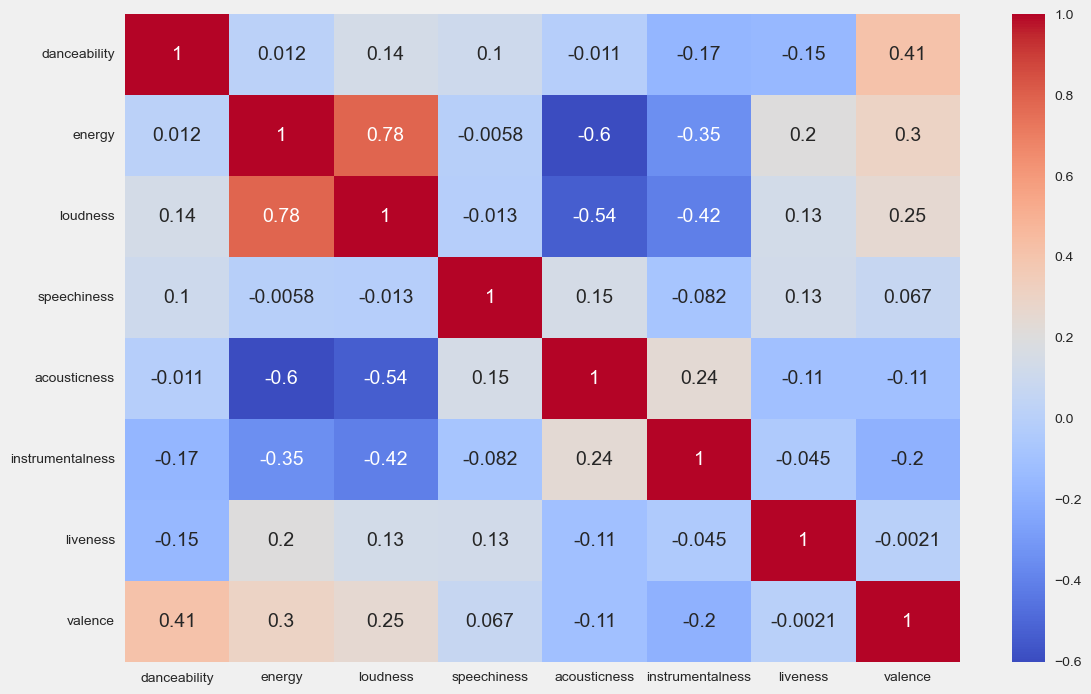

In [118]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[audio_feature_numerical_keys].corr(), annot=True, cmap='coolwarm')
plt.show()


## Preparacion para el clustering
### Normalizacion
Dado que usaremos k-means, necesitamos nomalizar para realizar el calculo de distancias correctamente.

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



from yellowbrick.cluster import KElbowVisualizer

La idea es usar TF-IDF (Term Frecuency - Inverse Document Frecuency) para representar los generos como vectores numericos

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                571 non-null    object 
 1   name              571 non-null    object 
 2   artist            571 non-null    object 
 3   genre             571 non-null    object 
 4   danceability      571 non-null    float64
 5   energy            571 non-null    float64
 6   loudness          571 non-null    float64
 7   speechiness       571 non-null    float64
 8   acousticness      571 non-null    float64
 9   instrumentalness  571 non-null    float64
 10  liveness          571 non-null    float64
 11  valence           571 non-null    float64
 12  tempo             571 non-null    float64
 13  time_signature    571 non-null    int64  
 14  key               571 non-null    int64  
 15  mode              571 non-null    int64  
dtypes: float64(9), int64(3), object(4)
memory us

In [121]:
# preparacion para el clustering
# preparar los datos de entrada

# mezclar los valores tf-idf con las variables numericas

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['genre'])


tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
print(tfidf_df.shape)
tfidf_df.head()

 # (571, 161) 


(571, 161)


,album,alternative,ambient,andean,anime,arequipeno,argentina,argentine,argentino,art,...,uruguaya,uruguayo,valenciana,veneto,venezolano,venezuelan,vgm,video,viral,weirdcore
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.671921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.671921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.727573,0.0


161 columnas, cuando agregemos otras caracteristicas es posible que las columnas pierdan importancia debido a la alta dimencionalidad, por ello reduciremos la dimencionalidad antes de combinarlos con los metadatos del audio

para este caso, PCA no pudo determinar matematicamente el numero de componentes, asi que le solicitaremos disminuirlos en funcion de la varianza

In [122]:
#pca = PCA(n_components='mle', svd_solver='full') # no puede estimar automaticamente el n componentes
pca = PCA(n_components=0.75, svd_solver='full')  # 75% de la varianza explicada
tfidf_df_reduced = pca.fit_transform(tfidf_df)

print(f'PCA redujo las categorias a un {tfidf_df_reduced.shape[1]/tfidf_df.shape[1]:.2%}')
print(f'{tfidf_df.shape[1]} to {tfidf_df_reduced.shape[1]}')


PCA redujo las categorias a un 22.98%
161 to 37


Integramos las otras categorias

In [123]:
df = pd.concat([df, tfidf_df], axis=1)
#  respaldar genre id y name
df_respaldo = df[['genre', 'id', 'name', 'artist']].copy()
df = df.drop(columns=['genre', 'id', 'name', 'artist', 'key', 'mode', 'time_signature', 'tempo', 'loudness'])

# nromalizamos
scaler = StandardScaler()
X = scaler.fit_transform(df)
print(len(df))
print(len(X))


571
571


## Clustering

Ahora si :D

### K-Means 

#### Seleccion de nro de Clusterns
Se usara el metodo del codo, para emplear un criterio experto. Nos recomienda 6 clusters. Se puede mejorar con el [Metodo de la silueta](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py), tal como lo recomienda scikit en la documentacion

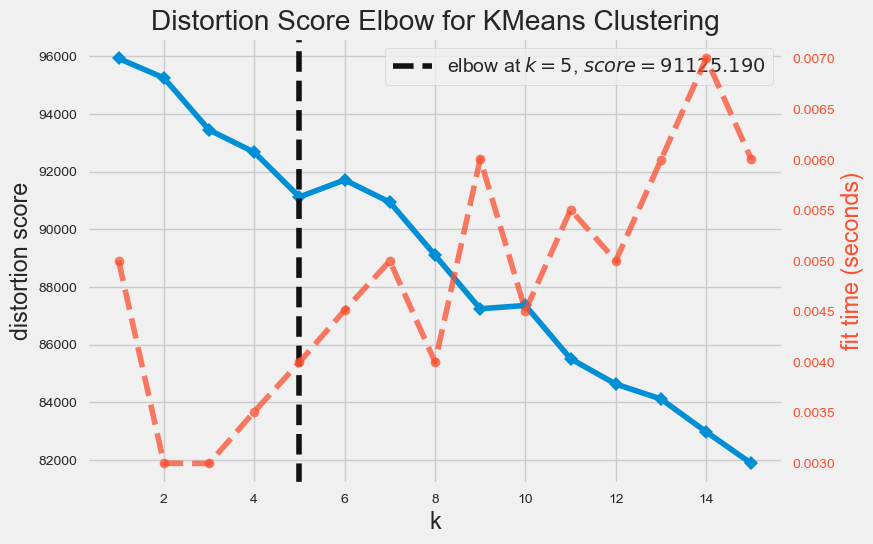

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [136]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,16)) # 
visualizer.fit(X)      
visualizer.show()        

#### Entrenamiento del modelo

`k-means++` se usa para mejorar la seleccion de los cetroides iniciales usando `greedy k-means++`, simplemente realiza varios ensayos del tracional y escoge el mejor de ellos, donde `n_init` son los ensayos.

`max_iter` cuantas veces mandaremos k-means.

`tol` tolerancia relativa a la Norma de Frobenius (que es algo asi como el RMSE pero para matrices y la linea serian los centroides), dejamos su valor por defecto.
`algorithm` {“lloyd”, “elkan”}, elkan puede ser mas eficiente, pero consume mas memoria. (de momento no lo necesitamos)
`random_state` seed para reproducibilidad 





In [137]:
n_clusters = 5

kmeans = KMeans(n_clusters = n_clusters ,init='k-means++', n_init = 10 ,max_iter=10000, 
                 tol=0.0001, algorithm='lloyd', random_state=42)

kmeans.fit(X)
labels = kmeans.labels_   
centroides = kmeans.cluster_centers_   

df['cluster'] =  labels

In [138]:
df['cluster'].value_counts()

cluster
1    516
0     35
3     14
4      5
2      1
Name: count, dtype: int64

In [113]:
#plot = sns.pairplot(df, hue='cluster', diag_kind='kde', palette='Dark2', height=1.5)
#plt.show()


### Reduccion de dimensionalidad
Dado que usamos al menos 11 dimensiones para el clustering nos veremos obligados a reducir la dimensionalidad para poder observar los clusters sin dificultadad

In [139]:
from sklearn.decomposition import PCA
import plotly.express as px


# Ajustar el modelo PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X)


df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = df['cluster']


fig = px.scatter_3d(df_pca, 
                    x='PC1', 
                    y='PC2', 
                    z='PC3', 
                    color='cluster', 
                    height=800, 
                    width=800)

# Guardar el gráfico como un archivo HTML
fig.write_html("file5k.html")

# Mostrar el gráfico
fig.show()

Por si el grafico interactivo no se muestra en GH

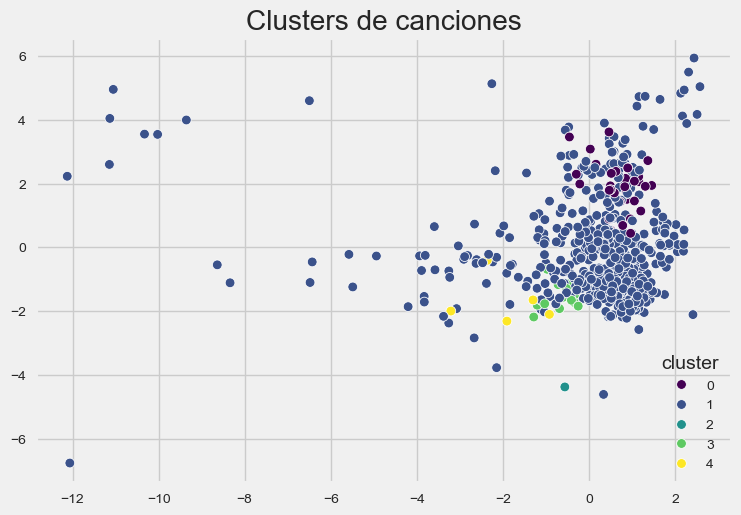

In [140]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis')
plt.title('Clusters de canciones')
plt.show()


Integramos los clusters a nuestro df simplificado

In [160]:
df_respaldo['cluster'] = df['cluster']
df_simply = df_respaldo.copy()

El primer cluster parece haberse realizado por la proximidad semantica de las nacionalidades. Por ello, posiblemente se replantee el analisis, dado que es un criterio escueto para la segmentacion de playlist.

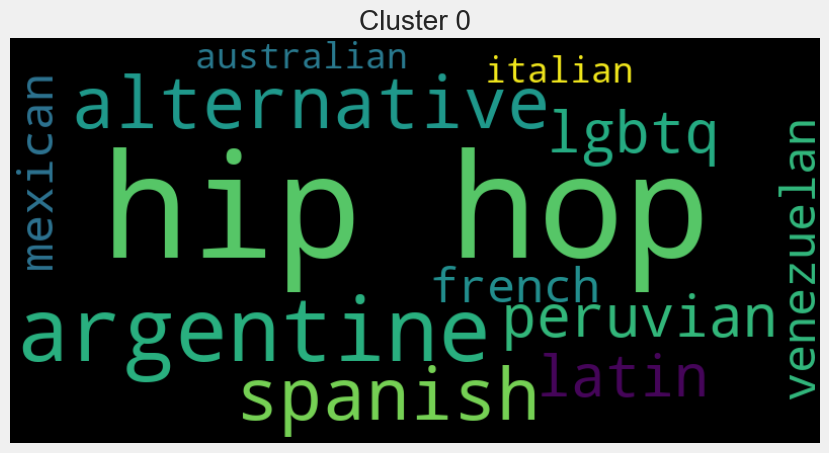

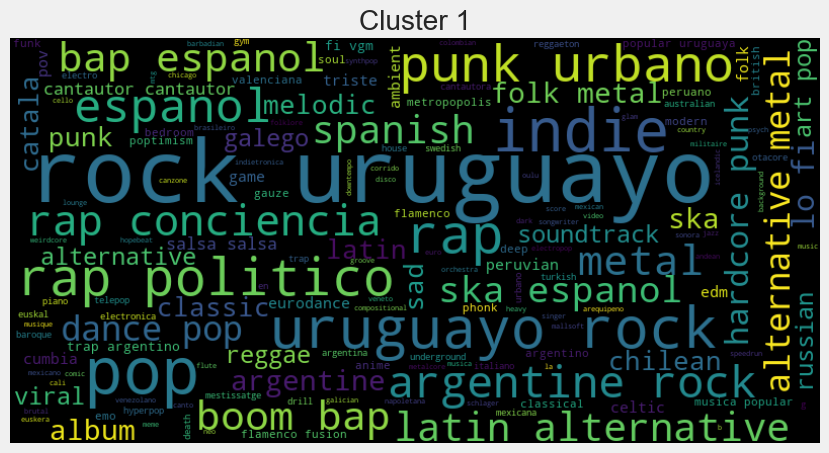

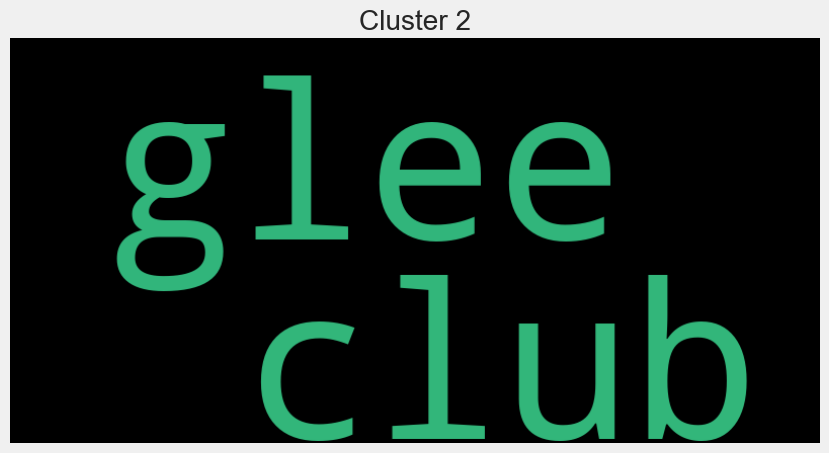

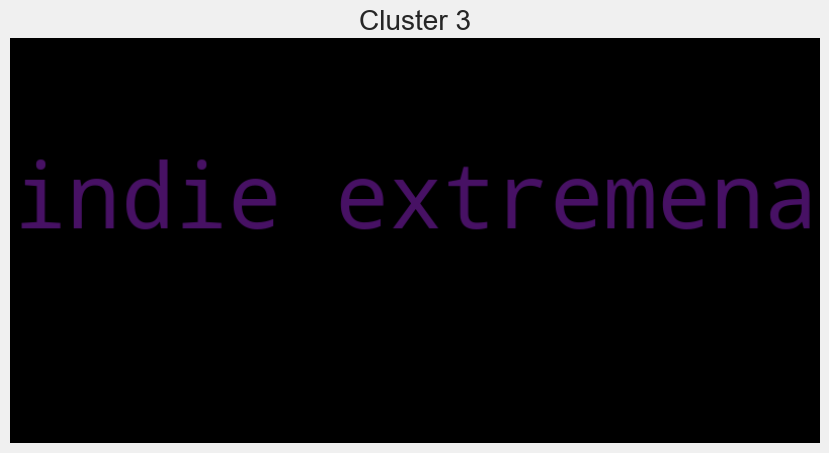

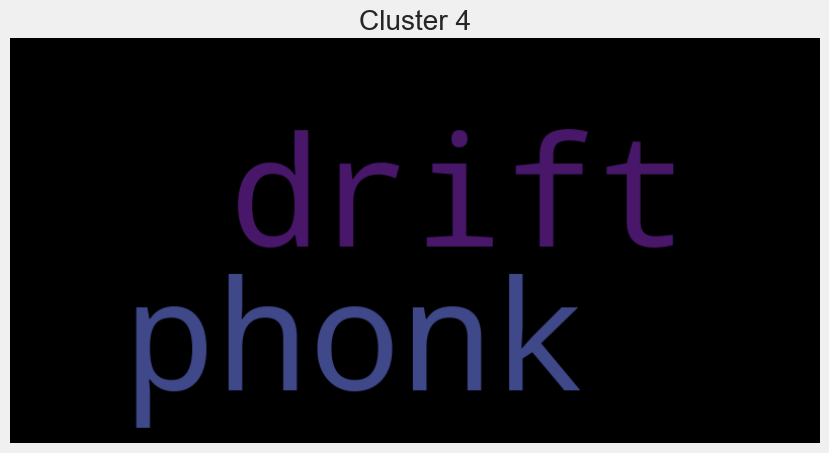

In [147]:
# nube de palabras para cada cluster
from wordcloud import WordCloud

for cluster in range(n_clusters):
    text = ' '.join(df_simply[df_simply['cluster'] == cluster]['genre'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster}')
    plt.show()

Aparentemente las nacionalidades solo eran variaciones de hiphop 

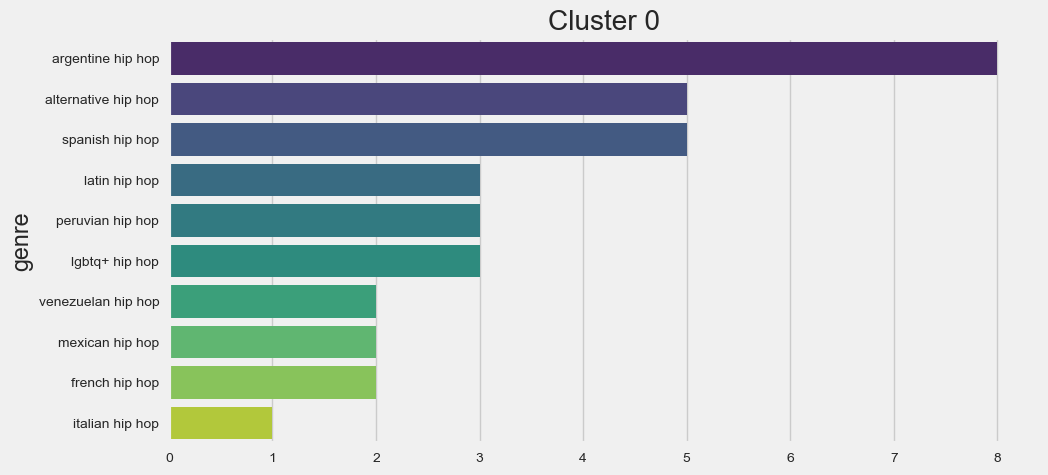

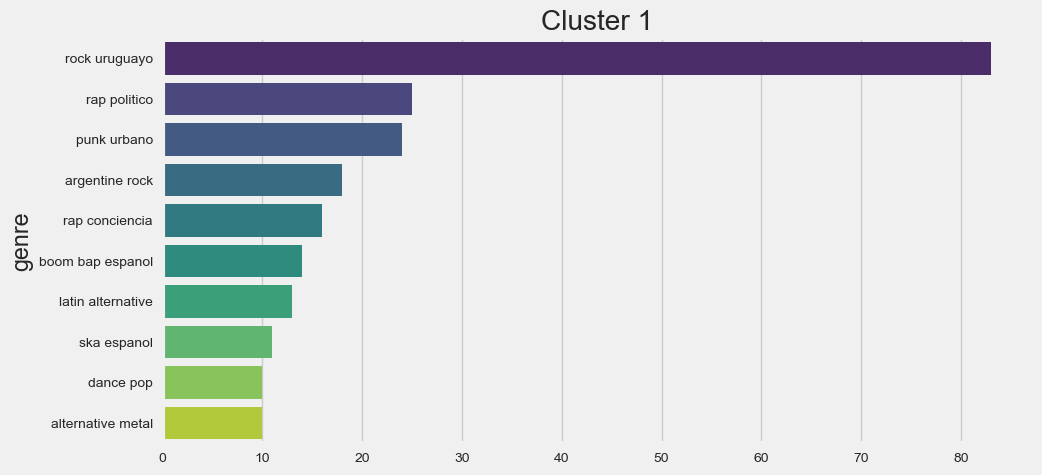

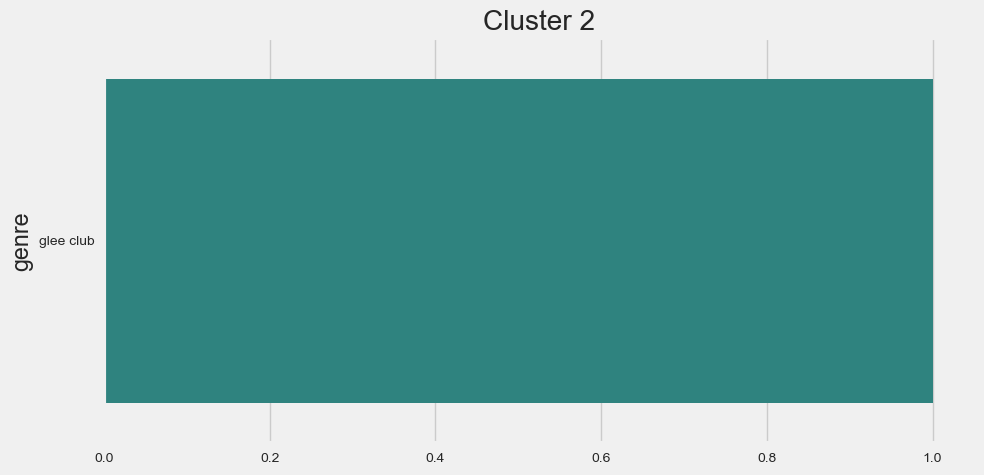

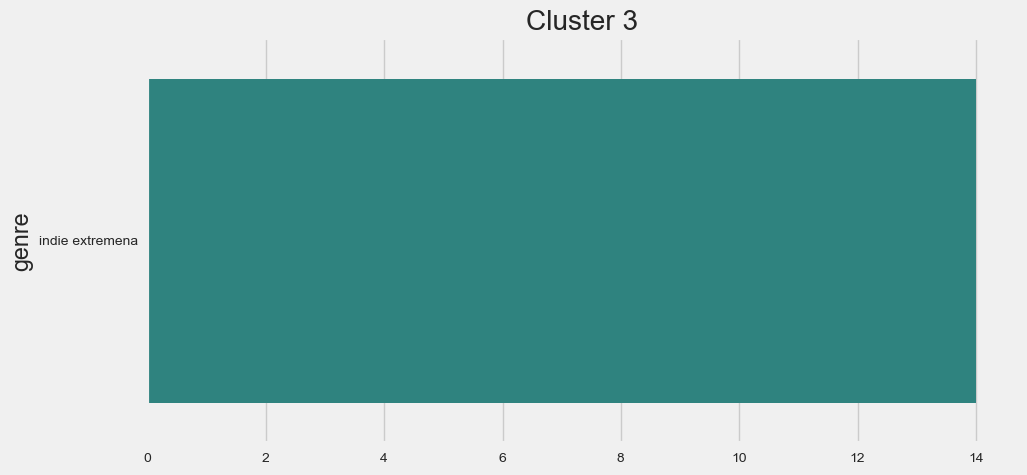

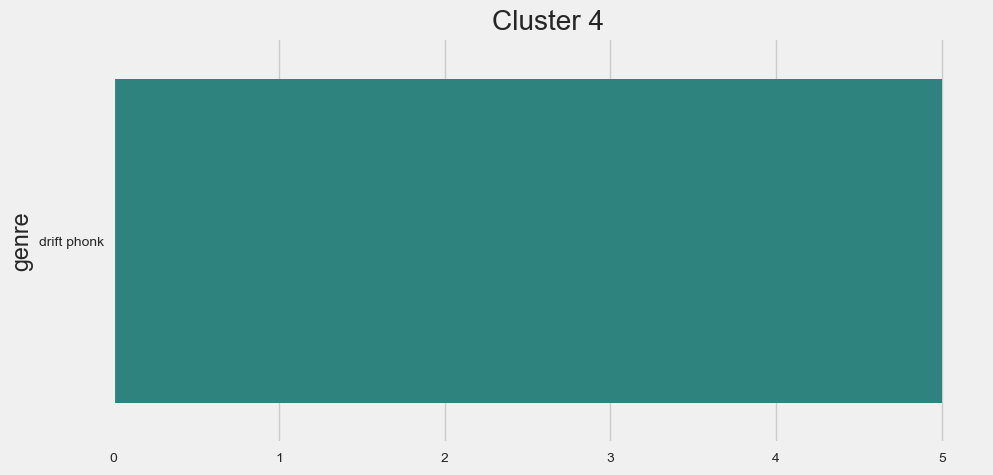

In [157]:
for cluster in range(n_clusters):
    top_genre = df_simply[df_simply['cluster'] == cluster]['genre'].value_counts().head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_genre.values, y=top_genre.index, palette='viridis')
    plt.title(f'Cluster {cluster}')
    plt.show()



In [161]:
df_simply.to_csv('playlist_spotify.csv', index=False)